# Image Segmentation by Unsupervised Learning

## import libraries

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import random
import os

## load data

In [44]:
directory_data  = './sample_data/'
filename_data   = 'assignment_10_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))

image_train     = data['image_train']
mask_train      = data['mask_train']

image_test      = data['image_test']
mask_test       = data['mask_test']

num_data_train  = image_train.shape[0]
num_data_test   = image_test.shape[0]

In [45]:
print('*************************************************')
print('size of x_train :', image_train.shape)
print('size of y_train :', mask_train.shape)
print('*************************************************')
print('size of x_test :', image_test.shape)
print('size of y_test :', mask_test.shape)
print('*************************************************')

*************************************************
size of x_train : (1000, 32, 32)
size of y_train : (1000, 32, 32)
*************************************************
size of x_test : (1000, 32, 32)
size of y_test : (1000, 32, 32)
*************************************************


In [46]:
# image augmentation을 위해 
image_train_double = np.concatenate((image_train, image_train), axis=0)
mask_train_double = np.concatenate((mask_train, mask_train), axis=0)
for _ in range(3):
  image_train = np.concatenate((image_train, image_train), axis=0)
  mask_train = np.concatenate((mask_train, mask_train), axis=0)
image_train = np.concatenate((image_train, image_train_double), axis=0)
mask_train = np.concatenate((mask_train, mask_train_double), axis=0)
print(image_train.shape)

(10000, 32, 32)


## plot data

In [47]:
def plot_image(title, image, mask):
    
    nRow = 2
    nCol = 4
    size = 3
    
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)
    
    for c in range(nCol):
        axes[0, c].imshow(image[c], cmap='gray')
        axes[1, c].imshow(mask[c], cmap='gray', vmin=0, vmax=1)

    plt.tight_layout()
    plt.show()

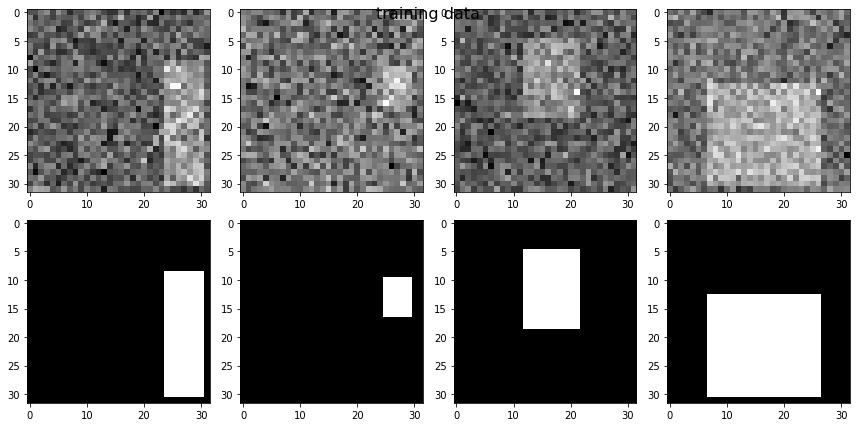

In [48]:
plot_image('training data', image_train, mask_train)

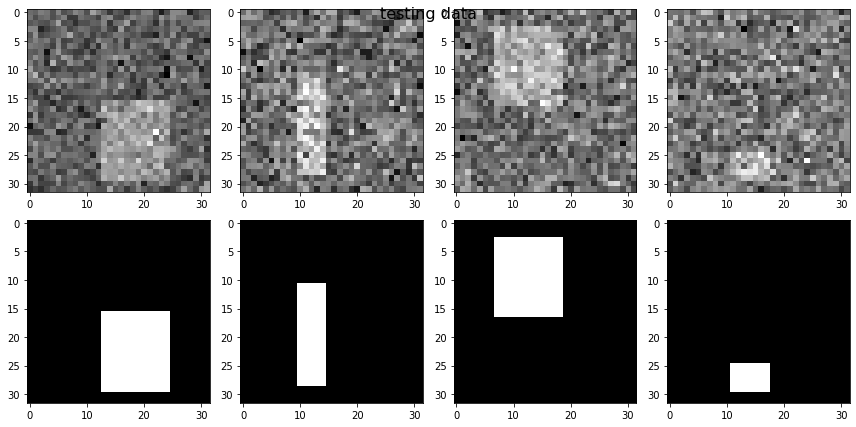

In [49]:
plot_image('testing data', image_test, mask_test)

In [50]:
## augmentation Definition
transforms1 = torch.nn.Sequential(
    transforms.RandomRotation(100),
)
# scripted_transforms = torch.jit.script(transformss)
transforms2 = torch.nn.Sequential(
    transforms.RandomHorizontalFlip(p=10),
)
transforms3 = torch.nn.Sequential(
    transforms.RandomVerticalFlip(p=20)
)
transforms4 = torch.nn.Sequential(
    transforms.Resize(48),
    transforms.RandomCrop(32)
)
transforms5 = torch.nn.Sequential(
     transforms.Resize(56),
    transforms.RandomCrop(32)
)
transforms6 = torch.nn.Sequential(
    transforms.Resize(16),
    transforms.Resize(32)
)
# Rotation again
transforms7 = torch.nn.Sequential(
    transforms.RandomAffine(30)
)
transforms8 = torch.nn.Sequential(
    transforms.RandomRotation(100),
)
transforms9 = torch.nn.Sequential(
    transforms.Resize(24),
    transforms.Resize(32)
)

## custom data loader for the PyTorch framework

In [51]:
class dataset(Dataset):
    
    def __init__(self, image, mask, use_transform=False):
        
        self.image          = image
        self.mask           = mask
        self.use_transform  = use_transform
    
    def __getitem__(self, index):
        
        image   = self.image[index]
        mask    = self.mask[index]

        image   = torch.FloatTensor(image).unsqueeze(dim=0)
        mask    = torch.FloatTensor(mask).unsqueeze(dim=0)

        # apply a data augmentation scheme
        if self.use_transform:
            # ==================================================
            # add codes for applying data augmentation 
            #

            if 1000 <= index < 2000:
                image = transforms1(image)
                mask = transforms1(mask)
            elif 2000 <= index < 3000:
                image = transforms2(image)
                mask = transforms2(mask)
            elif 3000 <= index < 4000:
                image = transforms3(image)
                mask = transforms3(mask)
            elif 4000 <= index < 5000:
                image = transforms4(image)
                mask = transforms4(mask)
            elif 5000 <= index < 6000:
                image = transforms5(image)
                mask = transforms5(mask)
            elif 6000 <= index < 7000:
                image = transforms6(image)
                mask = transforms6(mask)
            elif 7000 <= index < 8000:
                image = transforms7(image)
                mask = transforms7(mask)
            elif 8000 <= index < 9000:
                image = transforms8(image)
                mask = transforms8(mask)
            elif 9000 <= index < 10000:
                image = transforms9(image)
                mask = transforms9(mask)
            
            #    
            # ==================================================

        return (image, mask)
    
    def __len__(self):

        number_image = self.image.shape[0]

        return number_image

## setting device

In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [53]:
print(device)

cuda


## construct datasets and dataloaders for testing and testing

In [54]:
# ==================================================
# determine the mini-batch size
#
size_minibatch      = 3000
#
# ==================================================

dataset_train       = dataset(image_train, mask_train, True)
dataset_test        = dataset(image_test, mask_test, False)

dataloader_train    = torch.utils.data.DataLoader(dataset_train, batch_size=size_minibatch, shuffle=True, drop_last=True)
dataloader_test     = torch.utils.data.DataLoader(dataset_test, batch_size=size_minibatch, shuffle=False, drop_last=False)

## construct a neural network 

In [55]:
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()

        # -------------------------------------------------
        # Encoder
        # -------------------------------------------------

        # Define function for redundant things
        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding,
                                 bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers) # *으로 list unpacking 

            return cbr

        # Contracting path
        self.enc1_1 = CBR2d(in_channels=1, out_channels=64)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)

        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)

        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)

        # -------------------------------------------------
        # Decoder
        # -------------------------------------------------
         # Expansive path
        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)

        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels=512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)

        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)

        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)

        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)
        self.sgm = nn.Sigmoid()

        # -------------------------------------------------
        # Network
        # -------------------------------------------------

        self.initialize_weight()

    def forward(self,x):
    
        # print("11")
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)
        # print("22")
        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)
        # print("33")
        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)
        # print("44")
        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)
        # print("55")
        enc5_1 = self.enc5_1(pool4)
        # print("66")
        dec5_1 = self.dec5_1(enc5_1)
        # print("771")
        unpool4 = self.unpool4(dec5_1)
        cat4 = torch.cat((unpool4, enc4_2), dim=1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)
        # print("88")
        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)
        # print("99")
        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)
        # print("1010")
        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)
        # print("1111")
        fc_out = self.fc(dec1_1)
        out = self.sgm(fc_out)        
      
        return out

    # ======================================================================
    # initialize weights
    # ======================================================================
    def initialize_weight(self):
            
        for m in self.modules():
            
            if isinstance(m, nn.Conv2d):

                nn.init.xavier_uniform_(m.weight) 
                if m.bias is not None:

                    nn.init.constant_(m.bias, 1)
                    pass
                    
            elif isinstance(m, nn.BatchNorm2d):
                
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 1)
                
            elif isinstance(m, nn.Linear):

                nn.init.xavier_uniform_(m.weight)

                if m.bias is not None:
                    
                    nn.init.constant_(m.bias, 1)
                    pass

## build the network

In [56]:
model       = Network().to(device)

# ==================================================
# determine the optimiser and its associated hyper-parameters
#
learning_rate   = 0.001
alpha           = 0.001
number_epoch    = 15
optimizer       = torch.optim.Adam(model.parameters(), lr=learning_rate)
#
# ==================================================

## compute the prediction

In [57]:
def compute_prediction(model, data):

    prediction = model(data)

    return prediction

In [58]:
a = torch.Tensor(np.ones((100,1,32,32), dtype='float32'))
print(a.sum())
b = torch.Tensor(np.ones((100,1,32,32), dtype='float32'))
b[0][0][0] = 2
print(a.shape)
c = a * b
d=torch.sum(c, dim=(0,1,2,3))
print(d.shape)
print(d)
print(d.item())
e = torch.Tensor(np.ones((100,1), dtype='float32') * 2)
print( (d / e).shape)



tensor(102400.)
torch.Size([100, 1, 32, 32])
torch.Size([])
tensor(102432.)
102432.0
torch.Size([100, 1])


## compute the loss

In [59]:
def compute_estimate(data, prediction):
    # ==================================================
    # fill up the blank
    #
    # parameters are mini-batch
    estimate = [0,0]
    #a
    estimate[0] = torch.sum(data * prediction, dim=(1,2,3), keepdim=True) / torch.sum(prediction, dim=(1,2,3), keepdim=True)
    #b
    estimate[1] = torch.sum(data * (1 - prediction), dim=(1,2,3), keepdim=True) / torch.sum(1 - prediction, dim=(1,2,3), keepdim=True)

    #
    # ==================================================

    return estimate

In [60]:
# temp_a = torch.Tensor(np.ones((100,1,32,32), dtype='float32'))
# print(temp_a.sum())
# temp_b = torch.Tensor(np.ones((100,1,32,32), dtype='float32') * 3)
# print(temp_a.shape)
# b = torch.sum(temp_a, dim=(2,3), keepdim=True)
# print(b.shape)
# print(b[0])
# bb = b.repeat(1,1,32,32)
# print(bb.shape)
# print(bb[0])
# # -> [100]을 [100,1,32,32]로 만들어야함
# # bb = torch.full((100,1,32,32), 2)


    

# # print(bb.shape)


# d = compute_estimate(temp_a, temp_b)
# print(d[1].shape)
# print(d[1])



In [61]:
def compute_loss_data_fidelity(data, prediction):
    # ==================================================
    # fill up the blank
    # 
    a, b = compute_estimate(data, prediction)
    a = a.repeat(1,1,32,32)
    b = b.repeat(1,1,32,32)
    
    loss = prediction * torch.pow((data - a), 2) + (1 - prediction) * torch.pow((data - b), 2)
    loss = loss.sum()
    num_pixel = 32 * 32
    
    loss = loss / (num_pixel * size_minibatch)
    #
    # ==================================================

    return loss

In [62]:
def compute_loss_regularization(prediction):
    # ==================================================
    # fill up the blank
    # 

    x_dif_sum = abs(prediction[:,:, :,1: ] - prediction[:,:, :,:31]).sum()
    y_dif_sum = abs(prediction[:,:, 1:,:] - prediction[:,:,:31,:]).sum()
    num_pixel = 32 * 32

    loss = (x_dif_sum + y_dif_sum) / (num_pixel * size_minibatch)

    #
    # ==================================================
    
    return loss

In [63]:
temp_aa = torch.Tensor(np.ones((100,1,32,32), dtype='float32'))
temp_bb = torch.Tensor(np.ones((100,1,32,32), dtype='float32'))
temp_cc = compute_loss_regularization(temp_aa)
temp_dd = compute_loss_data_fidelity(temp_aa, temp_bb)
print(temp_dd.shape)

torch.Size([])


In [64]:
def compute_loss(data, prediction, alpha):
    # ==================================================
    # fill up the blank
    #

    loss_data_fidelity  = compute_loss_data_fidelity(data, prediction)
    loss_regularization = compute_loss_regularization(prediction)
    loss                = loss_data_fidelity + alpha * loss_regularization

    #
    # ==================================================

    return (loss, loss_data_fidelity, loss_regularization)

## compute the loss value

In [65]:
def compute_loss_value(loss):
    
    loss_value = loss.item()
    
    return loss_value

## compute the accuracy

In [66]:
def compute_accuracy(prediction, mask):
    
    prediction1 = prediction.squeeze(axis=1)
    prediction2 = 1 - prediction.squeeze(axis=1)
    binary1     = (prediction1 >= 0.5)
    binary2     = (prediction2 >= 0.5)
    mask        = mask.squeeze(axis=1).bool()
    
    intersection1   = (binary1 & mask).float().sum((1, 2))
    intersection2   = (binary2 & mask).float().sum((1, 2))
    union1          = (binary1 | mask).float().sum((1, 2))
    union2          = (binary2 | mask).float().sum((1, 2))

    eps         = 1e-8
    correct1    = (intersection1 + eps) / (union1 + eps)
    correct2    = (intersection2 + eps) / (union2 + eps)
    accuracy1   = correct1.mean() * 100.0
    accuracy2   = correct2.mean() * 100.0
    
    accuracy    = torch.max(accuracy1, accuracy2)
    accuracy    = accuracy.cpu() 
    
    return accuracy

## Variable for the learning curves

In [67]:
loss_train_mean     = np.zeros(number_epoch)
loss_train_std      = np.zeros(number_epoch)
accuracy_train_mean = np.zeros(number_epoch)
accuracy_train_std  = np.zeros(number_epoch)

loss_test_mean      = np.zeros(number_epoch)
loss_test_std       = np.zeros(number_epoch)
accuracy_test_mean  = np.zeros(number_epoch)
accuracy_test_std   = np.zeros(number_epoch)

loss_train_data_fidelity_mean   = np.zeros(number_epoch)
loss_train_data_fidelity_std    = np.zeros(number_epoch)
loss_train_regularization_mean  = np.zeros(number_epoch)
loss_train_regularization_std   = np.zeros(number_epoch)

loss_test_data_fidelity_mean    = np.zeros(number_epoch)
loss_test_data_fidelity_std     = np.zeros(number_epoch)
loss_test_regularization_mean   = np.zeros(number_epoch)
loss_test_regularization_std    = np.zeros(number_epoch)

## train

In [68]:
def train(model, optimizer, dataloader):

    loss_epoch                  = []
    loss_data_fidelity_epoch    = []
    loss_regularization_epoch   = []
    accuracy_epoch              = []

    model.train()

    for index_batch, (image, mask) in enumerate(dataloader):

        image       = image.to(device)
        mask        = mask.to(device)
        
        # ==================================================
        # fill up the blank
        #
        prediction  = compute_prediction( model, image )
        (loss, loss_data_fidelity, loss_regularization) = compute_loss( image, prediction, alpha )
        
        # print(type(loss))
        # print(loss)
        loss_value                  = compute_loss_value(loss)
        loss_data_fidelity_value    = compute_loss_value(loss_data_fidelity)
        loss_regularization_value   = compute_loss_value(loss_regularization)
        accuracy                    = compute_accuracy( prediction, mask )
        #
        # ==================================================
        
        loss_epoch.append(loss_value)
        loss_data_fidelity_epoch.append(loss_data_fidelity_value)
        loss_regularization_epoch.append(loss_regularization_value)
        accuracy_epoch.append(accuracy)

        # update the model    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_mean   = np.mean(loss_epoch)
    loss_std    = np.std(loss_epoch)

    loss_data_fidelity_mean = np.mean(loss_data_fidelity_epoch)
    loss_data_fidelity_std  = np.std(loss_data_fidelity_epoch)

    loss_regularization_mean    = np.mean(loss_regularization_epoch)
    loss_regularization_std     = np.std(loss_regularization_epoch)
    
    accuracy_mean   = np.mean(accuracy_epoch)
    accuracy_std    = np.std(accuracy_epoch)

    loss                = {'mean' : loss_mean, 'std' : loss_std}
    loss_data_fidelity  = {'mean' : loss_data_fidelity_mean, 'std' : loss_data_fidelity_std}
    loss_regularization = {'mean' : loss_regularization_mean, 'std' : loss_regularization_std}
    accuracy            = {'mean' : accuracy_mean, 'std' : accuracy_std}

    return (loss, loss_data_fidelity, loss_regularization, accuracy)

## test

In [69]:
def test(model, dataloader):

    loss_epoch                  = []
    loss_data_fidelity_epoch    = []
    loss_regularization_epoch   = []
    accuracy_epoch              = []

    model.eval()

    for index_batch, (image, mask) in enumerate(dataloader):

        image       = image.to(device)
        mask        = mask.to(device)
        
        # ==================================================
        # fill up the blank
        #
        prediction  = compute_prediction( model, image )
        (loss, loss_data_fidelity, loss_regularization) = compute_loss( image, prediction, alpha )
        
        loss_value                  = compute_loss_value(loss)
        loss_data_fidelity_value    = compute_loss_value(loss_data_fidelity)
        loss_regularization_value   = compute_loss_value(loss_regularization)
        accuracy                    = compute_accuracy( prediction, mask )
        #
        # ==================================================

        loss_epoch.append(loss_value)
        loss_data_fidelity_epoch.append(loss_data_fidelity_value)
        loss_regularization_epoch.append(loss_regularization_value)
        accuracy_epoch.append(accuracy)

    loss_mean   = np.mean(loss_epoch)
    loss_std    = np.std(loss_epoch)

    loss_data_fidelity_mean = np.mean(loss_data_fidelity_epoch)
    loss_data_fidelity_std  = np.std(loss_data_fidelity_epoch)

    loss_regularization_mean    = np.mean(loss_regularization_epoch)
    loss_regularization_std     = np.std(loss_regularization_epoch)
    
    accuracy_mean   = np.mean(accuracy_epoch)
    accuracy_std    = np.std(accuracy_epoch)

    loss                = {'mean' : loss_mean, 'std' : loss_std}
    loss_data_fidelity  = {'mean' : loss_data_fidelity_mean, 'std' : loss_data_fidelity_std}
    loss_regularization = {'mean' : loss_regularization_mean, 'std' : loss_regularization_std}
    accuracy            = {'mean' : accuracy_mean, 'std' : accuracy_std}

    return (loss, loss_data_fidelity, loss_regularization, accuracy)

## train and test

In [70]:
# ================================================================================
# 
# iterations for epochs
#
# ================================================================================
for i in tqdm(range(number_epoch)):
    
    # ================================================================================
    # 
    # training
    #
    # ================================================================================
    (loss_train, loss_data_fidelity_train, loss_regularization_train, accuracy_train) = train(model, optimizer, dataloader_train)

    loss_train_mean[i]  = loss_train['mean']
    loss_train_std[i]   = loss_train['std']

    loss_train_data_fidelity_mean[i]    = loss_data_fidelity_train['mean']
    loss_train_data_fidelity_std[i]     = loss_data_fidelity_train['std']

    loss_train_regularization_mean[i]   = loss_regularization_train['mean']
    loss_train_regularization_std[i]    = loss_regularization_train['std']

    accuracy_train_mean[i]  = accuracy_train['mean']
    accuracy_train_std[i]   = accuracy_train['std']

    # ================================================================================
    # 
    # testing
    #
    # ================================================================================
    (loss_test, loss_data_fidelity_test, loss_regularization_test, accuracy_test) = test(model, dataloader_test)

    loss_test_mean[i]  = loss_test['mean']
    loss_test_std[i]   = loss_test['std']

    loss_test_data_fidelity_mean[i]    = loss_data_fidelity_test['mean']
    loss_test_data_fidelity_std[i]     = loss_data_fidelity_test['std']

    loss_test_regularization_mean[i]   = loss_regularization_test['mean']
    loss_test_regularization_std[i]    = loss_regularization_test['std']

    accuracy_test_mean[i]  = accuracy_test['mean']
    accuracy_test_std[i]   = accuracy_test['std']

100%|██████████| 15/15 [01:00<00:00,  4.02s/it]


---

## functions for presenting the results

---

In [71]:
def function_result_01():
    
    title           = 'loss (training)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'loss'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(loss_train_mean)), loss_train_mean, '-', color = color_mean)
    plt.fill_between(range(len(loss_train_mean)), loss_train_mean - loss_train_std, loss_train_mean + loss_train_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [72]:
def function_result_02():
    
    title           = 'loss - data fidelity (training)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'loss'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(loss_train_data_fidelity_mean)), loss_train_data_fidelity_mean, '-', color = color_mean)
    plt.fill_between(range(len(loss_train_data_fidelity_mean)), loss_train_data_fidelity_mean - loss_train_data_fidelity_std, loss_train_data_fidelity_mean + loss_train_data_fidelity_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [73]:
def function_result_03():
    
    title           = 'loss - regularization (training)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'loss'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(loss_train_regularization_mean)), loss_train_regularization_mean, '-', color = color_mean)
    plt.fill_between(range(len(loss_train_regularization_mean)), loss_train_regularization_mean - loss_train_regularization_std, loss_train_regularization_mean + loss_train_regularization_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [74]:
def function_result_04():
    
    title           = 'loss (testing)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'loss'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(loss_test_mean)), loss_test_mean, '-', color = color_mean)
    plt.fill_between(range(len(loss_test_mean)), loss_test_mean - loss_test_std, loss_test_mean + loss_test_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [75]:
def function_result_05():
    
    title           = 'loss - data fidelity (testing)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'loss'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(loss_test_data_fidelity_mean)), loss_test_data_fidelity_mean, '-', color = color_mean)
    plt.fill_between(range(len(loss_test_data_fidelity_mean)), loss_test_data_fidelity_mean - loss_test_data_fidelity_std, loss_test_data_fidelity_mean + loss_test_data_fidelity_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [76]:
def function_result_06():
    
    title           = 'loss - regularization (testing)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'loss'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(loss_test_regularization_mean)), loss_test_regularization_mean, '-', color = color_mean)
    plt.fill_between(range(len(loss_test_regularization_mean)), loss_test_regularization_mean - loss_test_regularization_std, loss_test_regularization_mean + loss_test_regularization_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [77]:
def function_result_07():
    
    title           = 'accuracy (training)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'accuracy'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(accuracy_train_mean)), accuracy_train_mean, '-', color = color_mean)
    plt.fill_between(range(len(accuracy_train_mean)), accuracy_train_mean - accuracy_train_std, accuracy_train_mean + accuracy_train_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [78]:
def function_result_08():
    
    title           = 'accuracy (testing)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'accuracy'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(accuracy_test_mean)), accuracy_test_mean, '-', color = color_mean)
    plt.fill_between(range(len(accuracy_test_mean)), accuracy_test_mean - accuracy_test_std, accuracy_test_mean + accuracy_test_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [79]:
def function_result_09():

    nRow = 10
    nCol = 4 
    size = 3 
    
    title = 'training results'
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)

    number_data = len(dataset_train)
    index_image = np.linspace(0, number_data-1, nRow).astype(int)

    image       = torch.FloatTensor(dataset_train.image[index_image]).unsqueeze(dim=1).to(device)
    mask        = torch.FloatTensor(dataset_train.mask[index_image]).unsqueeze(dim=1).to(device)
    prediction  = compute_prediction(model, image)

    image       = image.detach().cpu().squeeze(axis=1)
    mask        = mask.detach().cpu().squeeze(axis=1)
    prediction  = prediction.detach().cpu().squeeze(axis=1)
    binary      = (prediction >= 0.5)

    for r in range(nRow):

            axes[r, 0].imshow(image[r], cmap='gray')
            axes[r, 1].imshow(prediction[r], cmap='gray', vmin=0, vmax=1)
            axes[r, 2].imshow(binary[r], cmap='gray', vmin=0, vmax=1)
            axes[r, 3].imshow(mask[r], cmap='gray', vmin=0, vmax=1)

            axes[r, 0].xaxis.set_visible(False)
            axes[r, 1].xaxis.set_visible(False)
            axes[r, 2].xaxis.set_visible(False)
            axes[r, 3].xaxis.set_visible(False)
            
            axes[r, 0].yaxis.set_visible(False)
            axes[r, 1].yaxis.set_visible(False)
            axes[r, 2].yaxis.set_visible(False)
            axes[r, 3].yaxis.set_visible(False)
            
    plt.tight_layout()
    plt.show()

In [80]:
def function_result_10():
    
    nRow = 10
    nCol = 4 
    size = 3 

    title = 'testing results'
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)

    number_data = len(dataset_test)
    index_image = np.linspace(0, number_data-1, nRow).astype(int)
    
    image       = torch.FloatTensor(dataset_test.image[index_image]).unsqueeze(dim=1).to(device)
    mask        = torch.FloatTensor(dataset_test.mask[index_image]).unsqueeze(dim=1).to(device)
    prediction  = compute_prediction(model, image)

    image       = image.detach().cpu().squeeze(axis=1)
    mask        = mask.detach().cpu().squeeze(axis=1)
    prediction  = prediction.detach().cpu().squeeze(axis=1)
    binary      = (prediction >= 0.5)

    for r in range(nRow):
    
            axes[r, 0].imshow(image[r], cmap='gray')
            axes[r, 1].imshow(prediction[r], cmap='gray', vmin=0, vmax=1)
            axes[r, 2].imshow(binary[r], cmap='gray', vmin=0, vmax=1)
            axes[r, 3].imshow(mask[r], cmap='gray', vmin=0, vmax=1)

            axes[r, 0].xaxis.set_visible(False)
            axes[r, 1].xaxis.set_visible(False)
            axes[r, 2].xaxis.set_visible(False)
            axes[r, 3].xaxis.set_visible(False)
            
            axes[r, 0].yaxis.set_visible(False)
            axes[r, 1].yaxis.set_visible(False)
            axes[r, 2].yaxis.set_visible(False)
            axes[r, 3].yaxis.set_visible(False)
            
    plt.tight_layout()
    plt.show()

In [81]:
def function_result_11():
    
    print('final training accuracy = %9.8f' % (accuracy_train_mean[-1]))

In [82]:
def function_result_12():
    
    print('final testing accuracy = %9.8f' % (accuracy_test_mean[-1]))

---

## results 

---


################################################################################
#
# RESULT # 01
#
################################################################################



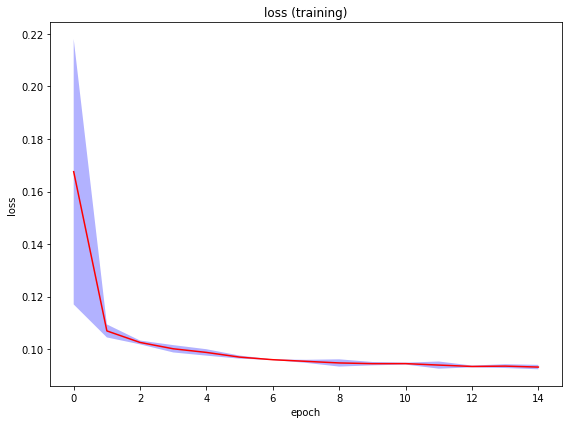


################################################################################
#
# RESULT # 02
#
################################################################################



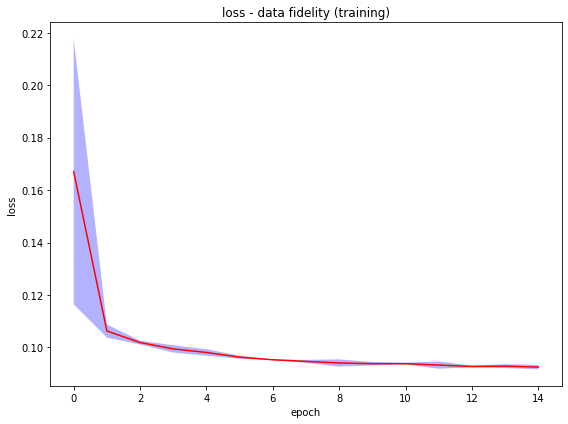


################################################################################
#
# RESULT # 03
#
################################################################################



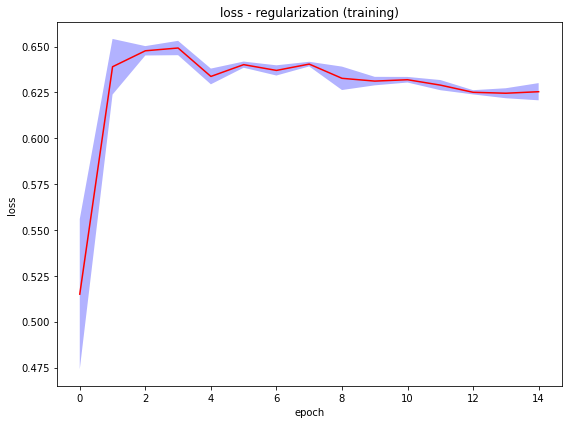


################################################################################
#
# RESULT # 04
#
################################################################################



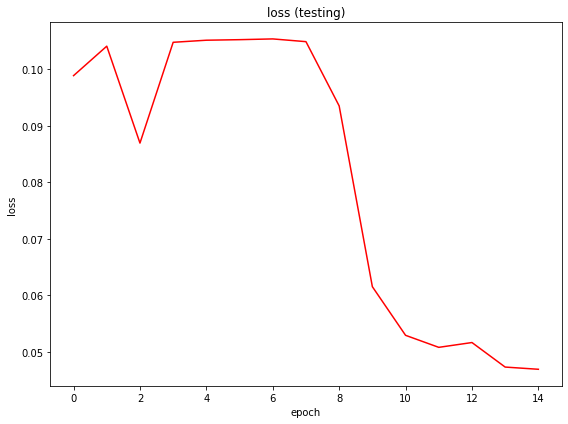


################################################################################
#
# RESULT # 05
#
################################################################################



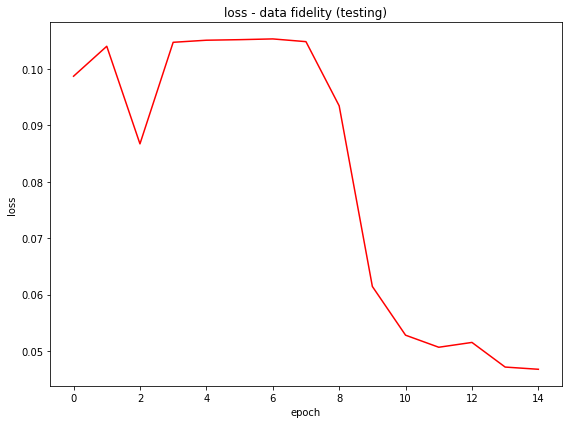


################################################################################
#
# RESULT # 06
#
################################################################################



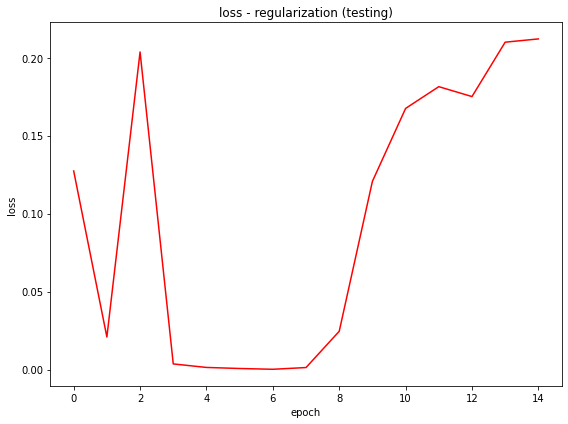


################################################################################
#
# RESULT # 07
#
################################################################################



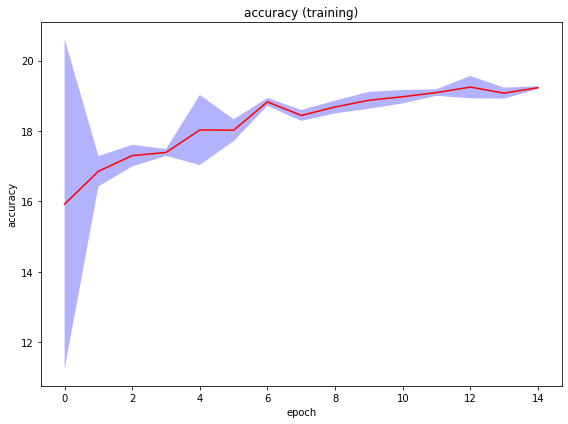


################################################################################
#
# RESULT # 08
#
################################################################################



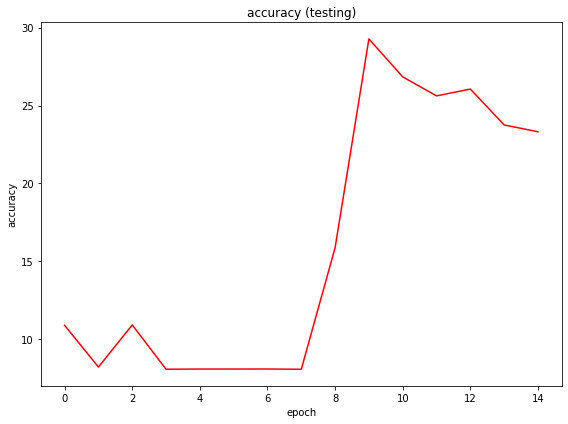


################################################################################
#
# RESULT # 09
#
################################################################################



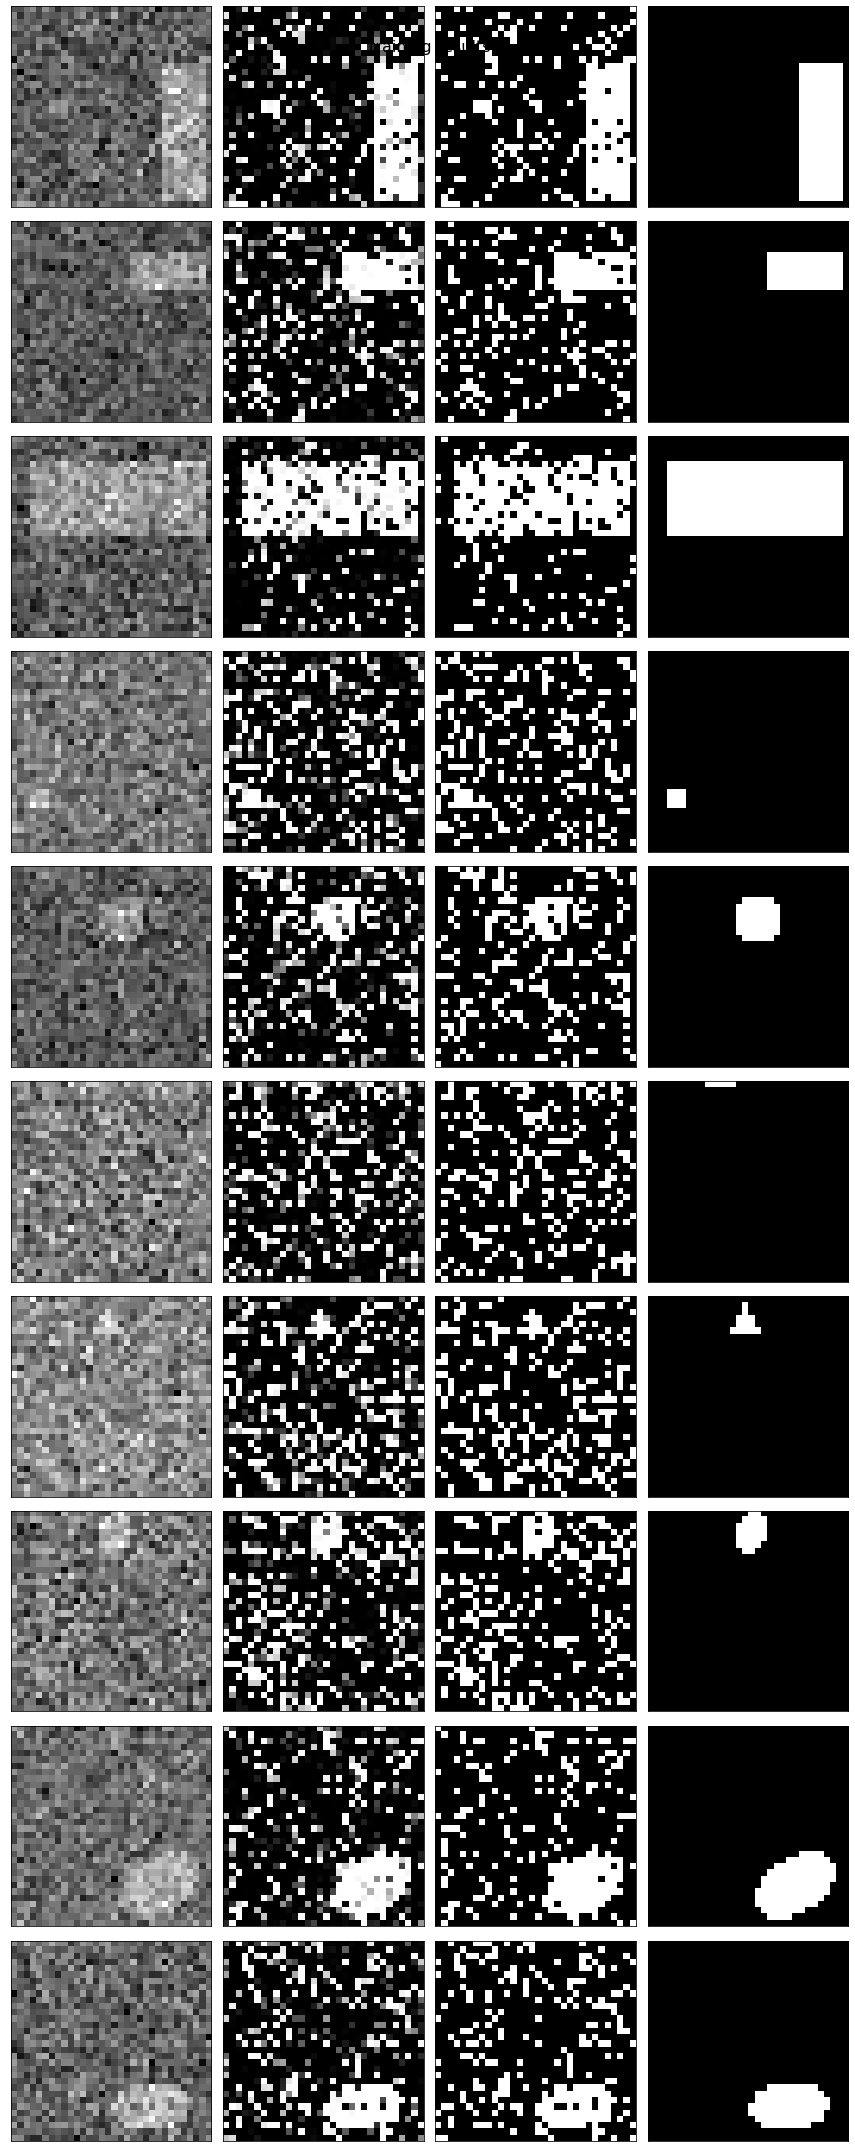


################################################################################
#
# RESULT # 10
#
################################################################################



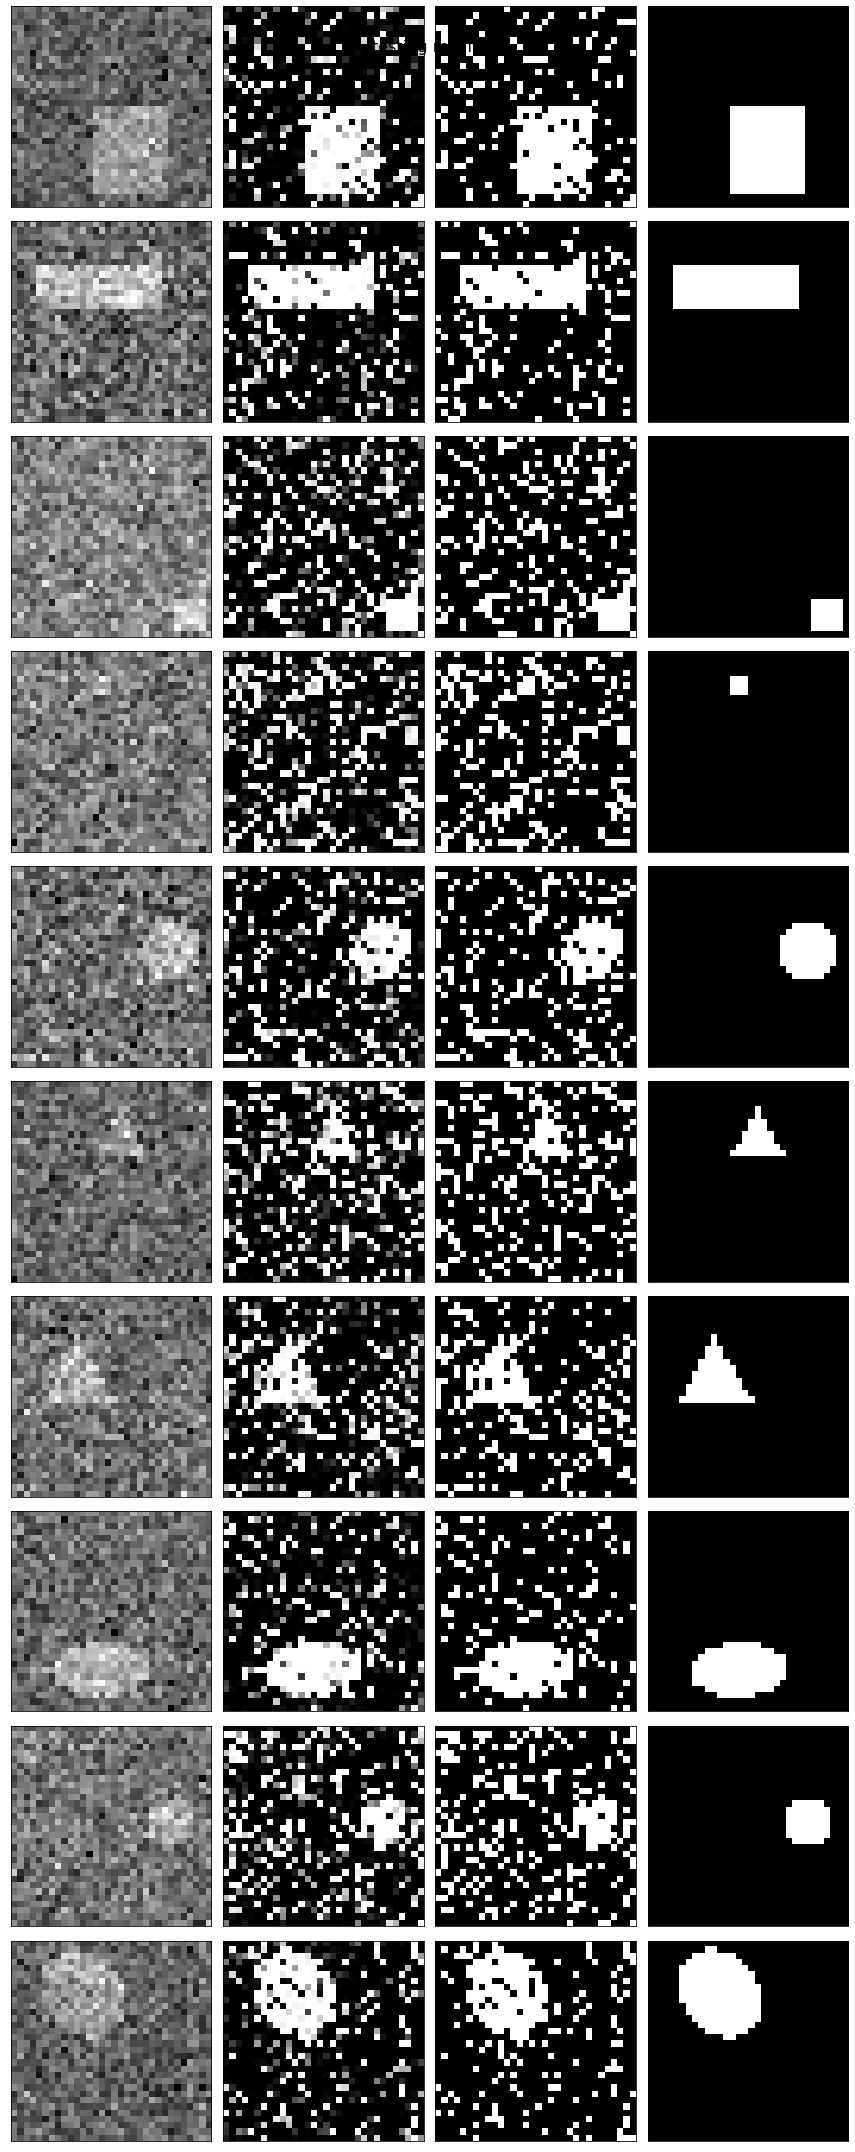


################################################################################
#
# RESULT # 11
#
################################################################################

final training accuracy = 19.23000145

################################################################################
#
# RESULT # 12
#
################################################################################

final testing accuracy = 23.31264496


In [83]:
number_result = 12 

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1) 
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)